# Finding topics in United Nations General Assembly debates

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import NMF

Let's start this off by loading the data and taking a look at it. We have the text of each debate speech, the year and session it occurred in, and the country that gave it. There are over 7500 speeches in total, spanning the the period from 1970 to 2015. 

In [2]:
data = pd.read_csv('un-general-debates.csv')
data.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


There are a few more speeches given in more recent years.

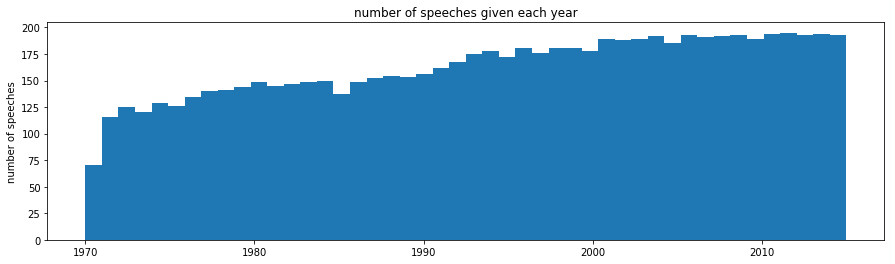

In [3]:
plt.figure(figsize=(15,4))
plt.hist(data.year, bins=len(data.year.unique()))
plt.ylabel('number of speeches')
plt.title('number of speeches given each year')
plt.show()

A first cut at topics, using bag-of-words and NMF. I'm excluding the basic English "stop words" from the NLTK library. These are words like "the", "of", etc. that don't add meaning to the speech.

In [4]:
stops = set(nltk.corpus.stopwords.words('english'))
bow = CountVectorizer(stop_words=stops)
bag = bow.fit_transform(data.text)

In [5]:
nmf = NMF(n_components=5)
W = nmf.fit_transform(bag)
H = nmf.components_

Let's look at some of the top words in each topic:

In [6]:
words = bow.get_feature_names()
words = np.array(words)
words[np.argsort(H, axis=1)][:,-20:]

array([['assembly', 'also', 'operation', 'session', 'general',
        'developed', 'community', 'nations', 'problems', 'co', 'south',
        'africa', 'new', 'must', 'developing', 'development', 'economic',
        'world', 'international', 'countries'],
       ['many', 'assembly', 'council', 'organization', 'one', 'also',
        'peace', 'security', 'global', 'rights', 'general', 'us', 'new',
        'states', 'development', 'human', 'must', 'world', 'united',
        'nations'],
       ['operation', 'disarmament', 'union', 'war', 'republic',
        'military', 'co', 'relations', 'weapons', 'peoples', 'security',
        'soviet', 'world', 'countries', 'peace', 'nations', 'nuclear',
        'international', 'united', 'states'],
       ['organization', 'cooperation', 'government', 'support',
        'process', 'human', 'region', 'economic', 'political', 'rights',
        'country', 'also', 'general', 'council', 'efforts',
        'development', 'community', 'peace', 'security', 'in

Hmmm. Some of these words aren't too meaningful in the context of the UN general assembly. Words like "nation" and "assembly" are going to be so common in these speeches as to be more or less meaningless in tying to distinguish between speech topics. So let's add to our list of stop words and run the NMF again.

In [7]:
stops2 = stops.union(set(['general', 'assembly',
        'government', 'country', 'people',
        'international', 'world', 'countries', 'also',
        'united', 'must', 'state', 'session',
        'nations', 'union'
        'policy', 'relations', 'nations', 'peoples',
        'region', 'political', 'country',
        'council']))

In [8]:
bow = CountVectorizer(stop_words=stops2)
bag = bow.fit_transform(data.text)

In [9]:
nmf = NMF(n_components=5)
W = nmf.fit_transform(bag)
H = nmf.components_

Looking at the top words in each topic again (note that the last word in each list is the top word):

In [10]:
words = bow.get_feature_names()
words = np.array(words)
words[np.argsort(H, axis=1)][:,-40:]

array([['force', 'east', 'efforts', 'foreign', 'problems', 'powers',
        'race', 'one', 'interests', 'important', 'situation', 'struggle',
        'independence', 'democratic', 'socialist', 'use', 'treaty',
        'forces', 'peaceful', 'non', 'economic', 'conference', 'europe',
        'new', 'operation', 'would', 'arms', 'policy', 'co',
        'disarmament', 'war', 'military', 'union', 'security', 'weapons',
        'peace', 'republic', 'soviet', 'nuclear', 'states'],
       ['action', 'well', 'financial', 'national', 'conflict', 'trade',
        'issues', 'continue', 'agenda', 'secretary', 'change', 'poverty',
        'climate', 'member', 'role', 'sustainable', 'reform',
        'important', 'work', 'regional', 'challenges', 'need', 'year',
        'organization', 'social', 'process', 'rights', 'developing',
        'support', 'states', 'cooperation', 'new', 'efforts', 'human',
        'community', 'economic', 'global', 'peace', 'security',
        'development'],
       ['self

Looks like we're getting some separation in the topics now. We might call them:
0) 

NMF gives us an "amount" that each topic contributes to each speech. Let's go ahead and assign each speech it's highest valued topic.

In [11]:
top_topic = np.argmax(W, axis=1)
data["top_topic"] = top_topic

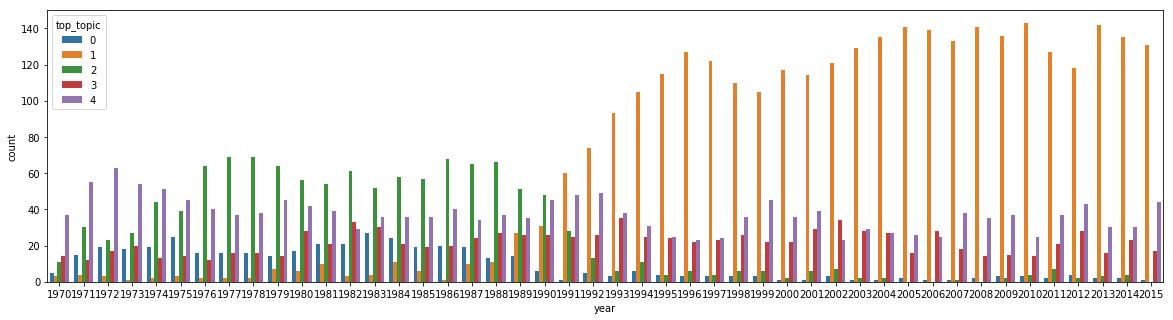

In [12]:
plt.figure(figsize=(20,5))
sns.countplot(x='year', hue='top_topic', data=data)

In [13]:
tfidf = TfidfVectorizer(stop_words=stops2, ngram_range=(1,3))
tf = tfidf.fit_transform(data.text)

In [14]:
nmf = NMF(n_components=5)
W = nmf.fit_transform(tf)
H = nmf.components_

In [15]:
words = tfidf.get_feature_names()
words = np.array(words)
words[np.argsort(H, axis=1)][:,-40:]

array([['southern', 'third', 'time', 'rights', 'developed', 'human',
        'great', 'mankind', 'hope', 'regime', 'powers', 'solution',
        'efforts', 'order', 'would', 'one', 'conference', 'apartheid',
        'problem', 'us', 'situation', 'new', 'independence', 'states',
        'community', 'delegation', 'problems', 'namibia', 'development',
        'developing', 'organization', 'african', 'operation',
        'south africa', 'co operation', 'peace', 'co', 'south',
        'economic', 'africa'],
       ['today', 'years', 'african', 'member', 'like', 'regional',
        'democratic', 'year', 'important', 'millennium', 'work',
        'sustainable', 'one', 'need', 'conflict', 'poverty', 'european',
        'democracy', 'social', 'would', 'challenges', 'support',
        'process', 'reform', 'organization', 'efforts', 'states', 'us',
        'terrorism', 'economic', 'new', 'community', 'global',
        'cooperation', 'human rights', 'rights', 'human', 'peace',
        'security',

In [16]:
words[np.argsort(H, axis=1)][:,:10:-1]

array([['africa', 'economic', 'south', ..., 'global process furthermore',
        'global process needs', 'global process non'],
       ['development', 'security', 'peace', ...,
        'pursued forthcoming months', 'pursued forthcoming',
        'pursued former israeli'],
       ['pacific', 'island', 'islands', ..., 'opposition freely',
        'opposition freedom africans', 'opposition freedom'],
       ['soviet', 'nuclear', 'states', ..., 'like speak bethlehem',
        'like speak briefly', 'like speak canada'],
       ['arab', 'israel', 'peace', ..., 'obligations resort peaceful',
        'obligations resort', 'obligations resolved meet']], dtype='<U51')

In [17]:
top_topic = np.argmax(W, axis=1)
data["top_topic"] = top_topic

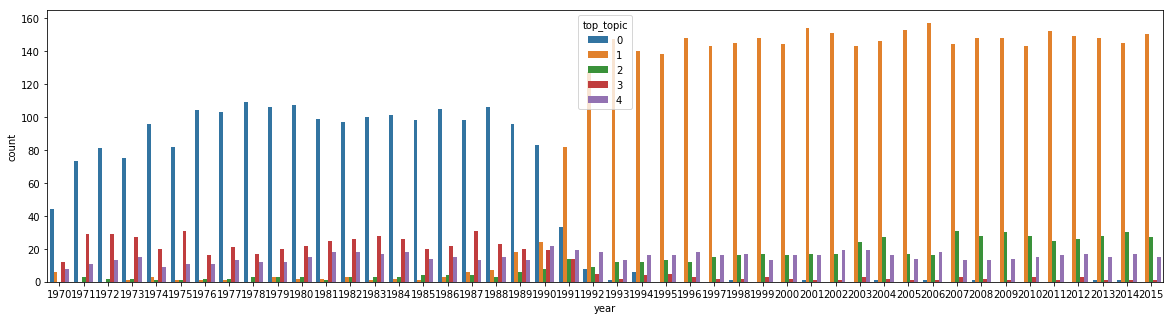

In [18]:
plt.figure(figsize=(20,5))
sns.countplot(x='year', hue='top_topic', data=data)

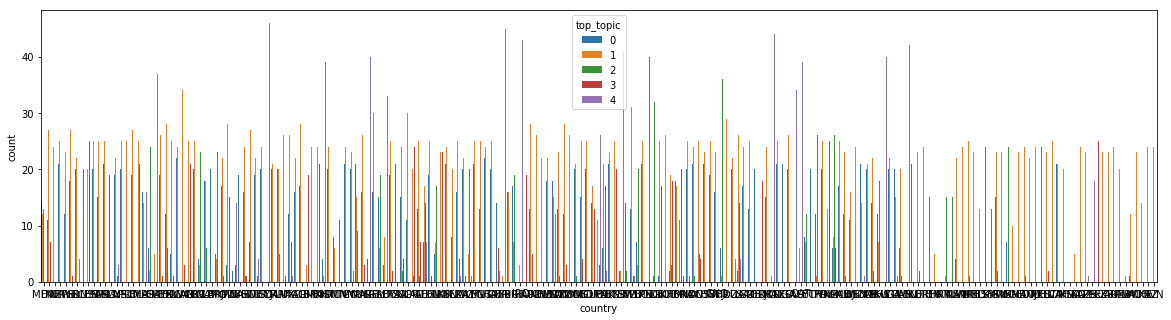

In [19]:
plt.figure(figsize=(20,5))
sns.countplot(x='country', hue='top_topic', data=data)

In [20]:
q = np.array([[1,2,3,4,5,6,7,8], [1,2,3,4,5,6,7,8], [1,2,3,4,5,6,7,8]])

In [21]:
q[:,:3:-1]

array([[8, 7, 6, 5],
       [8, 7, 6, 5],
       [8, 7, 6, 5]])